# Model optimisation

Model optimised based on data from [Tsutsumi _et al._ 2011](https://doi.org/10.1038/nsmb.2125).

This notebook only shows the optimisation strategy, the actual optimised paramters used in the model can be found in ``params.py``.

## Setup

In [1]:
#setup workspace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
from scipy.optimize import curve_fit
import cma

In [2]:
#set up initial conditions
##initial concentrations (nM) as outlines in Tsutsumi et al.
pre_wt = 1
pre_sl = 1
wt_dcr = 0
sl_dcr = 0
wt_dcr_star = 0
sl_dcr_star = 0
dcr_wt = 5 #free Dicer in WT system
dcr_sl = 5 #free Dicer in SL system
wt = 0
sl = 0

init_values = [pre_wt, pre_sl, wt_dcr, sl_dcr, wt_dcr_star, sl_dcr_star, dcr_wt, dcr_sl, wt, sl]

##measured affinities for wt, sl pre-miRNAs (nM)
Kd_wt = 25.4
Kd_sl = 147.7

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 #shared kd between both WT and SL

theta = np.log(np.array([ka_wt, ka_sl, kc_wt, kc_sl, kd])) #log theta to prevent negative reaction rates in optimisation

#experimental data from figure 1, tsutsumi et al. to pass to optimiser
##extracted from graph
WT_data = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_data = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])
##simulation time and time steps
time = np.array([0, 5, 10, 20, 40, 60])
minutes = 60

### Functions

In [3]:
#model
def optim_model(t, init_values, ka1, ka2, kc1, kc2, kd):
    """
    Model for optimising parameters for expanded model. Using short loop and wt maturing 
    miRNAs in separate Dicer pool.
    """   
    kb1 = ka2 * Kd_wt #Kd = kb / ka
    kb2 = ka2 * Kd_sl
    
    init_pMiR1, init_pMiR2, init_pMiR1_dcr, init_pMiR2_dcr, init_pMiR1_dcr_star, \
    init_pMiR2_dcr_star, init_dcr1, init_dcr2, init_miR1, init_miR2 = init_values
    
    pMiR1 = init_pMiR1_dcr * kb1 - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    pMiR1_dcr = init_pMiR1 * init_dcr1 * ka1 - init_pMiR1_dcr * (kb1 + kd)
    pMiR1_dcr_star = init_pMiR1 * init_dcr1 * kc1
    dcr1 = init_pMiR1_dcr * (kb1 + kd) - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    MiR1 = init_pMiR1_dcr * kd
    
    pMiR2 = init_pMiR2_dcr * kb2 - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    pMiR2_dcr = init_pMiR2 * init_dcr2 * ka2 - init_pMiR2_dcr * (kb2 + kd)
    pMiR2_dcr_star = init_pMiR2 * init_dcr2 * kc2
    dcr2 = init_pMiR2_dcr * (kb2 + kd) - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    MiR2 = init_pMiR2_dcr * kd

    
    return pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2
    

In [4]:
#calculate fraction diced
def frac_diced(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka1, ka2, kc1, kc2, kd = np.exp(theta)
        
    sol = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd))
    
    pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2 = sol.y
    
    diced1 = []
    diced2 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced1, diced2, sol.t

In [5]:
#create error function
def errorODE(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, diced2, ts = frac_diced(theta)
    
    data = np.array([[WT_data],
                     [short_data]])
    WT = np.interp(time, ts, diced1)
    short = np.interp(time, ts, diced2)

    
    model = np.array([[WT],
                      [short]])
    
    return np.sum(np.power((data-model), 2))
    

## Optimisation

In [6]:
#minimise with CMA-ES
##NB! Optimised values vary between optimisation runs!
res = cma.fmin(errorODE, theta, 2)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=454150, Fri Oct 27 12:56:50 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.688036118207833e-01 1.0e+00 1.89e+00  2e+00  2e+00 0:00.1
    2     16 6.452005447821370e-02 1.3e+00 1.82e+00  2e+00  2e+00 0:00.1
    3     24 2.643435390266813e-02 1.5e+00 1.94e+00  2e+00  2e+00 0:00.1
   92    736 1.875741587397103e-04 6.5e+01 2.09e-02  2e-03  8e-03 0:03.1
  100    800 1.875041927819174e-04 7.0e+01 1.64e-02  1e-03  6e-03 0:03.4
  200   1600 1.871598787051040e-04 4.8e+01 1.19e-03  2e-05  1e-04 0:06.8
  300   2400 1.871580757020759e-04 5.0e+01 3.18e-04  3e-06  9e-06 0:10.2
  400   3200 1.871582090653009e-04 2.0e+02 1.12e-04  4e-07  1e-06 0:13.8
  500   4000 1.871584336611136e-04 1.1e+03 7.64e-05  2e-07  4e-07 0:17.4
  505   4040 1.871581440325740e-04 1.5e+03 8.82e-05  2e-07  6e-07 0:17.7
termination on tolstagnation=226 (Fri Oct 27 12:57:09 2023)
final/bestever f-value = 1.885067e-04 1.860273e-

In [7]:
#error at end of optimisation
res[1]

0.00018602733457074612

### Plotting

In [8]:
#load logger
logger = res[-1]
#load function evaluations
f_dat = logger.load().data['f']
#loaf best f-value for each iteration
f_best = f_dat[:, 5]
evals = f_dat[:, 1]

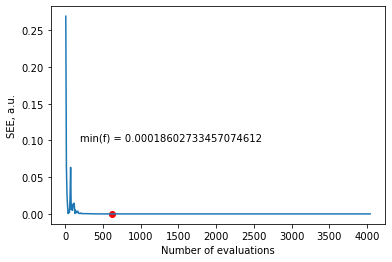

In [10]:
#plot error minimisation
fig, ax = plt.subplots()

ax.plot(evals,
        f_best)
for i in range(len(f_best)): #find where f was minimised and mark with red circle
    if f_best[i] == res[1]:
        ax.scatter(evals[i],
                   f_best[i],
                   marker = 'o',
                   color = 'red')
        
        
ax.set_xlabel('Number of evaluations')
ax.set_ylabel('SEE, a.u.')

ax.text(200, .1, f'min(f) = {res[1]}')

#plt.savefig(r'./figures/optim_f-mins.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [11]:
#fit experimental data with curve_fit
WT_popt, WT_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], WT_data[1:]) #exclude origin

short_popt, short_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], short_data[1:]) #exclude origin

#create array with curve_fit data
x = np.linspace(0,60,600)

WT_pred = np.zeros(len(x))
short_pred = np.zeros(len(x))

for i in range(1, len(x)):
    WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
    short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]

In [12]:
#find model data at set experimental timepoints
wt2, short2, ts2 = frac_diced(res[0])
wt_scatter2 = np.interp(time, ts2, wt2)
short_scatter2 = np.interp(time, ts2, short2)

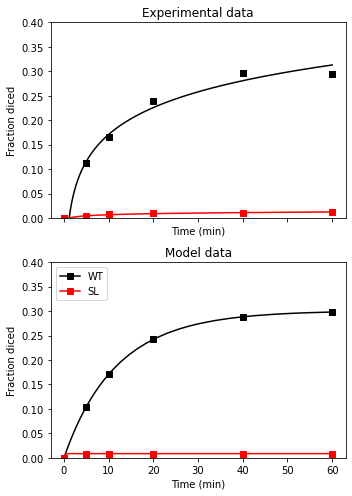

In [27]:
#plot experimental data with curve_fit, model data
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(x,
           short_pred,
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              short_data,
              marker = 's',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Experimental data')

ax[1].plot(ts2,
           wt2,
           color = 'black')
ax[1].plot(ts2,
           short2,
           color = 'red')
ax[1].scatter(time,
              wt_scatter2,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 's',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Model data')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'WT')
l2 = mlines.Line2D([], [], marker = 's', color = 'red', label = 'SL')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

#plt.savefig(r'./figures/exp-mod-data-fit.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

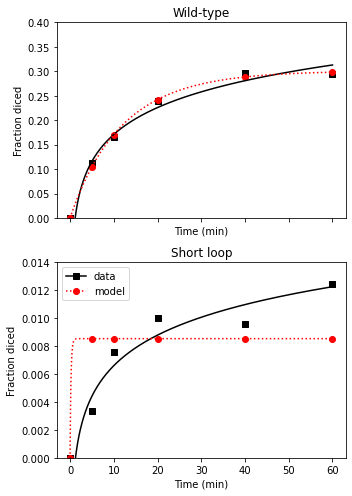

In [40]:
#plot overlaid data
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(ts2,
           wt2,
           linestyle = ':',
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              wt_scatter2,
              marker = 'o',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Wild-type')

ax[1].set_ylim(0, 0.014)

ax[1].plot(x,
           short_pred,
           color = 'black')
ax[1].plot(ts2,
           short2,
           linestyle = ':',
           color = 'red')
ax[1].scatter(time,
              short_data,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 'o',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Short loop')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', marker = 'o', color = 'red', label = 'model')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

#plt.savefig('./figures/overlay_optims.svg', dpi = 600, bbox_inches = 'tight')

plt.show()